In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import numpy as np
import math
import copy

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [3]:
T = 1000
beta = torch.linspace(10e-4, 0.02, T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
batch_size = 256
learning_rate = 1e-3
img_size = 28
num_epochs = 30

In [4]:
data_transform = transforms.Compose([ToTensor(), transforms.Lambda(lambda t: (t*2) - 1)])

train_dataset = datasets.MNIST(root='../../data', train = True, download = True, transform = data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../../data', train = False, download = True, transform = data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

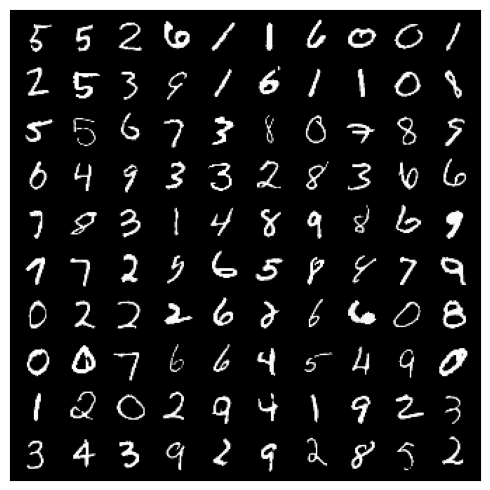

In [6]:
for image_batch, _ in train_dataloader:
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(make_grid(image_batch.data[:100],10,5))
    # plt.show()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    break

# Template Code
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=qWw50ui9IZ5q

In [7]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            if x.shape != residual_x.shape:
                x = TF.resize(x, size=residual_x.shape[2:])
            x = torch.cat((x, residual_x), dim=1)   
            x = up(x, t)
        return self.output(x)

In [9]:
model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62437601


In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [11]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

@torch.no_grad()
def sample_timestep(model, x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model):
    # Sample noise
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

In [12]:
def train_ddpm(model, train_dataloader, debug=False):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100 # Try more!
    
    for epoch in range(epochs):
        for step, (batch, _) in enumerate(train_dataloader):
            
            model.train()
            optimizer.zero_grad()
            t = torch.randint(0, T, (batch.shape[0],), device=device).long()
            loss = get_loss(model, batch, t)
            loss.backward()
            optimizer.step()
            
            if debug == True and epoch % 5 == 0 and step == 0:
                model.eval()
                print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
                sample_plot_image(model)

Epoch 0 | step 000 Loss: 0.8075355291366577 


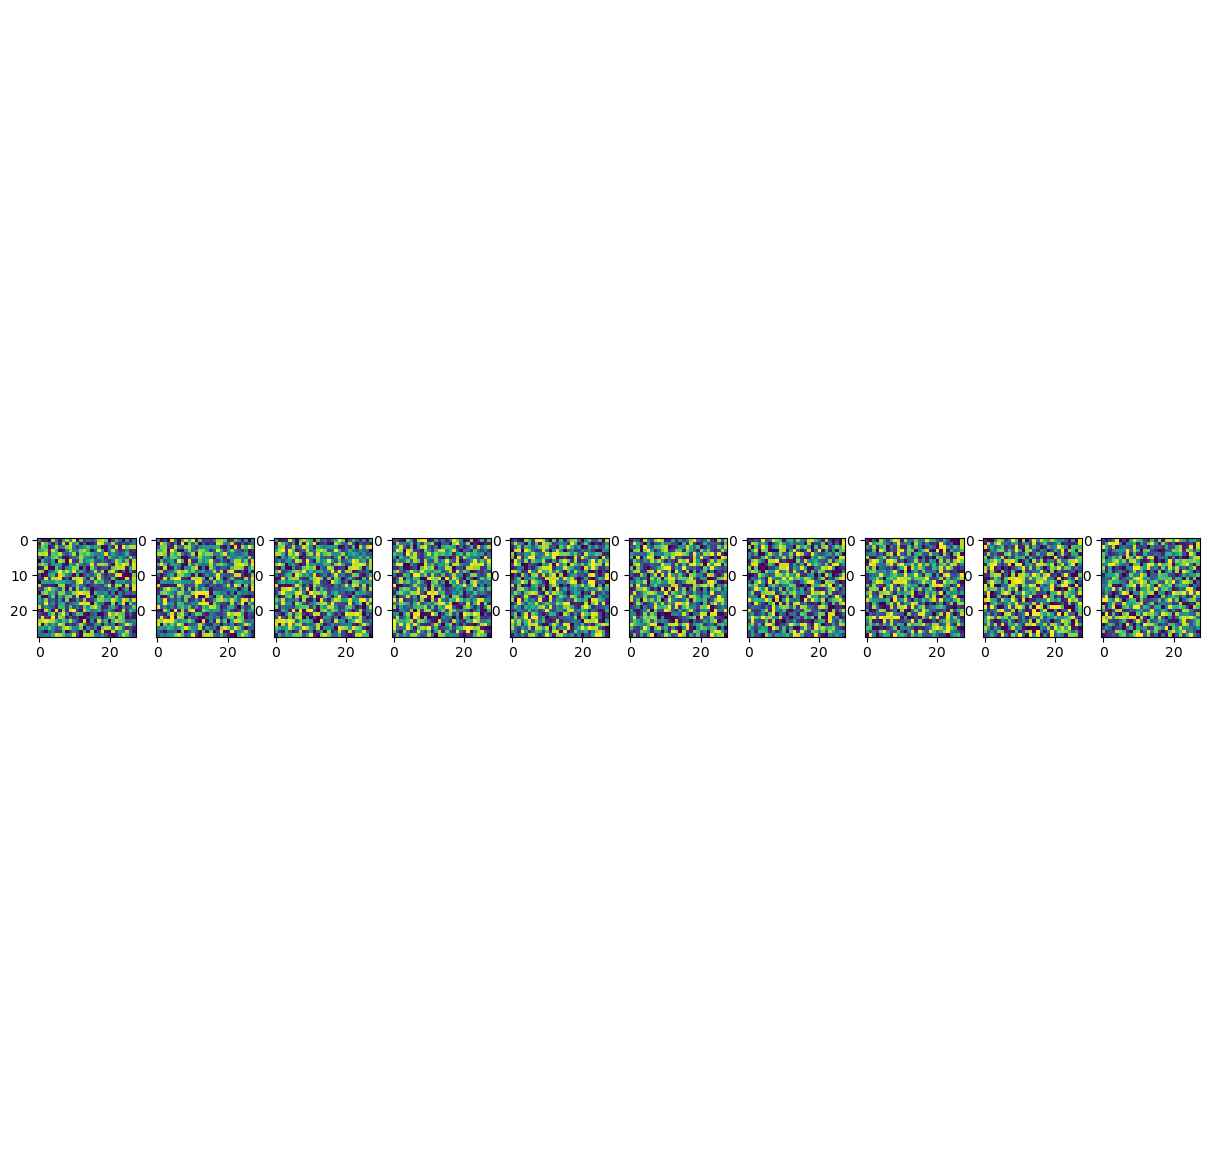

Epoch 5 | step 000 Loss: 0.09017372131347656 


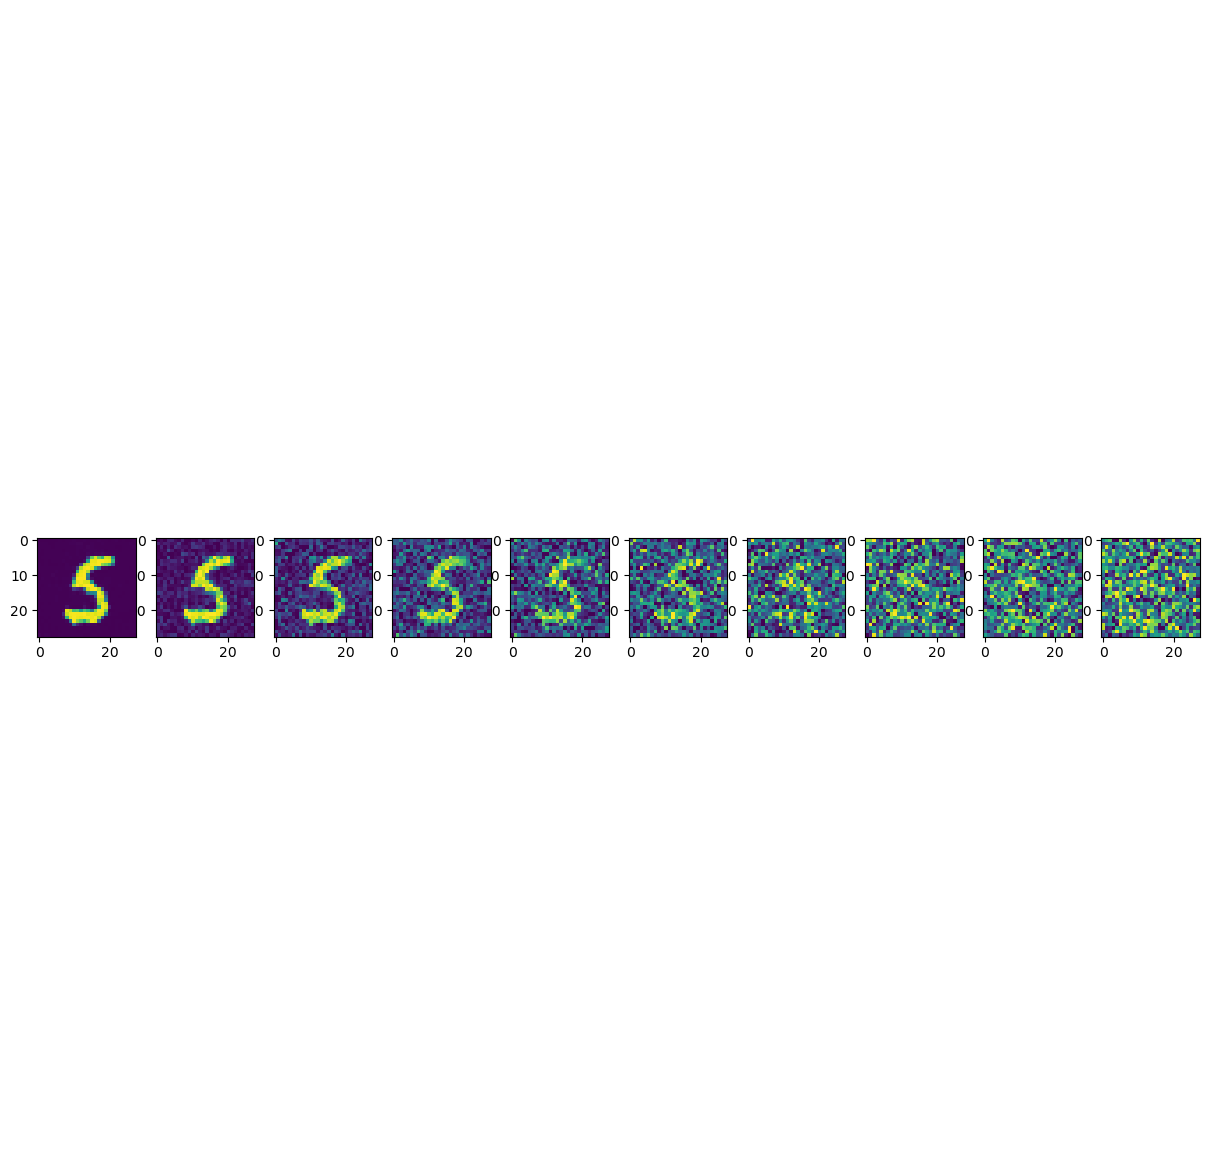

Epoch 10 | step 000 Loss: 0.09236899018287659 


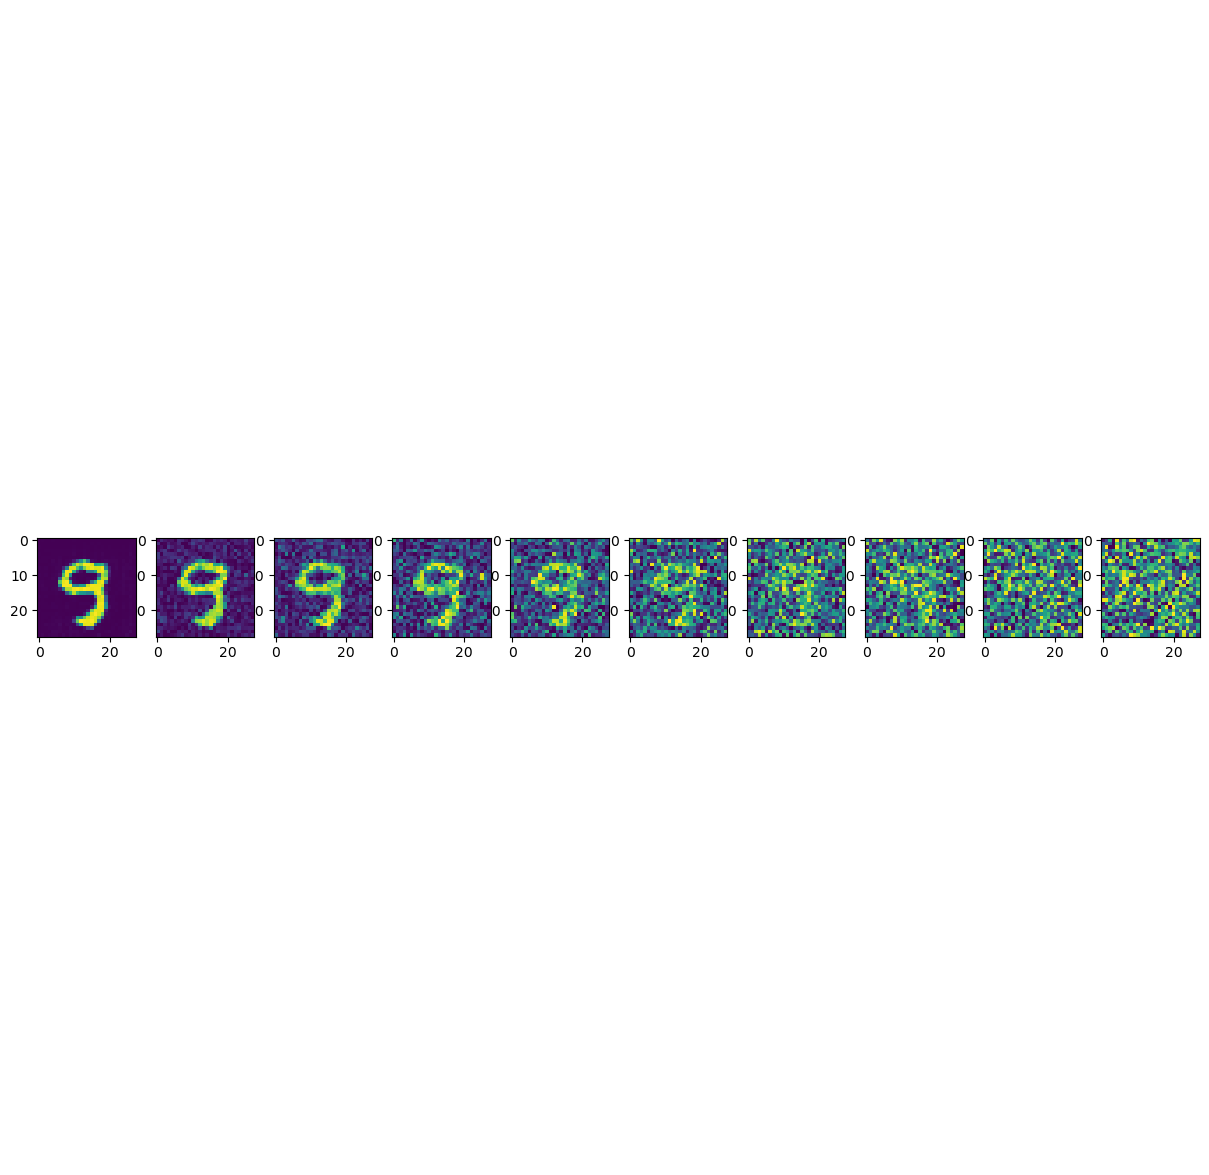

Epoch 15 | step 000 Loss: 0.07598849385976791 


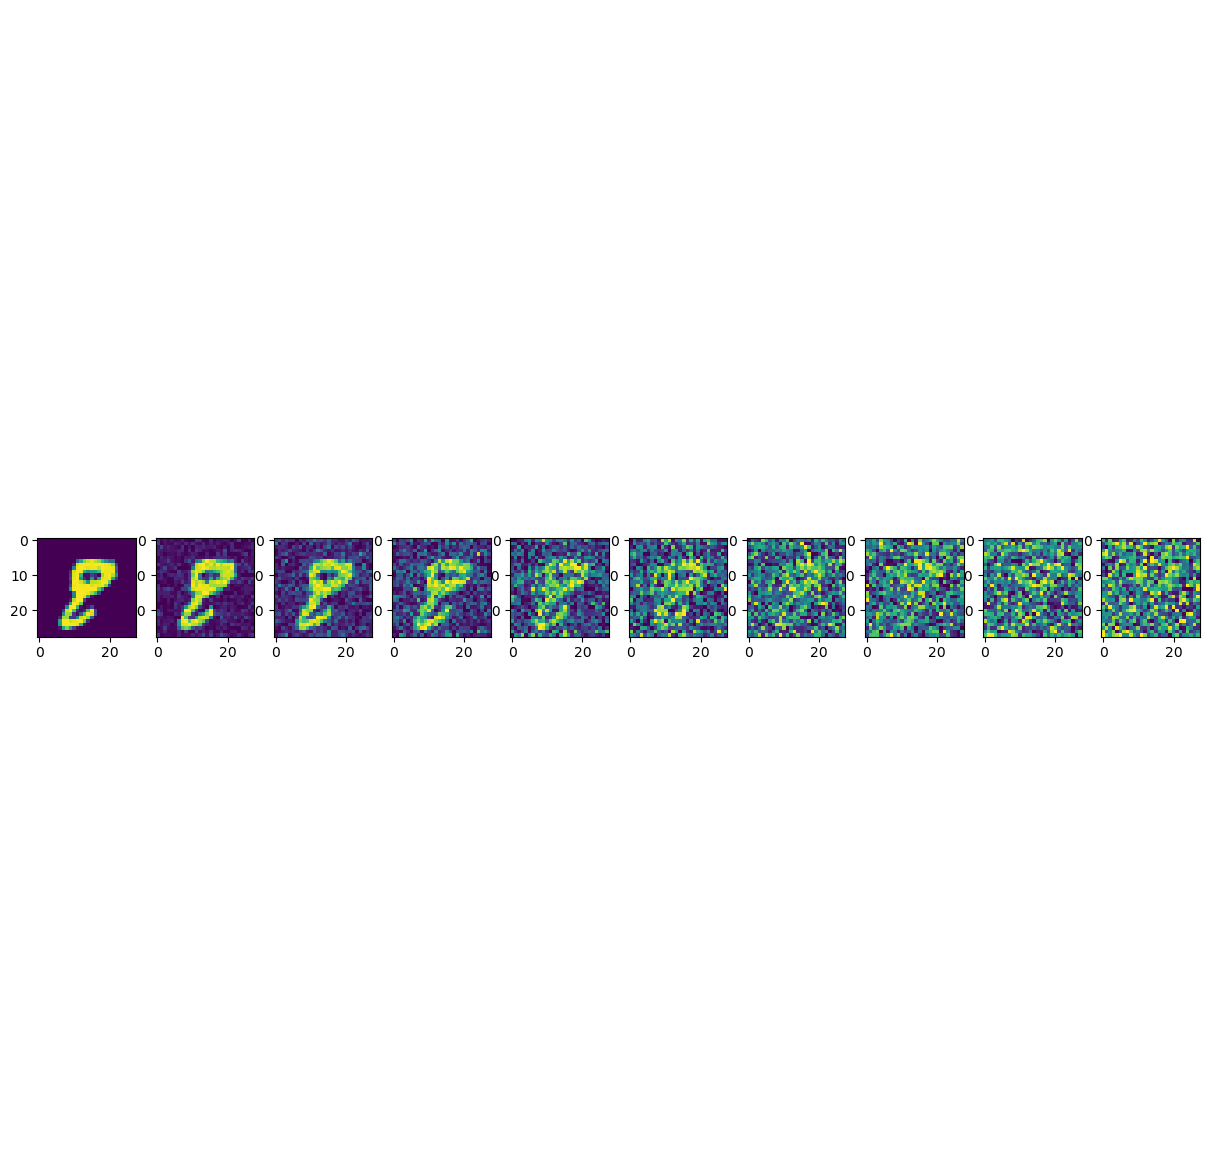

Epoch 20 | step 000 Loss: 0.08367323875427246 


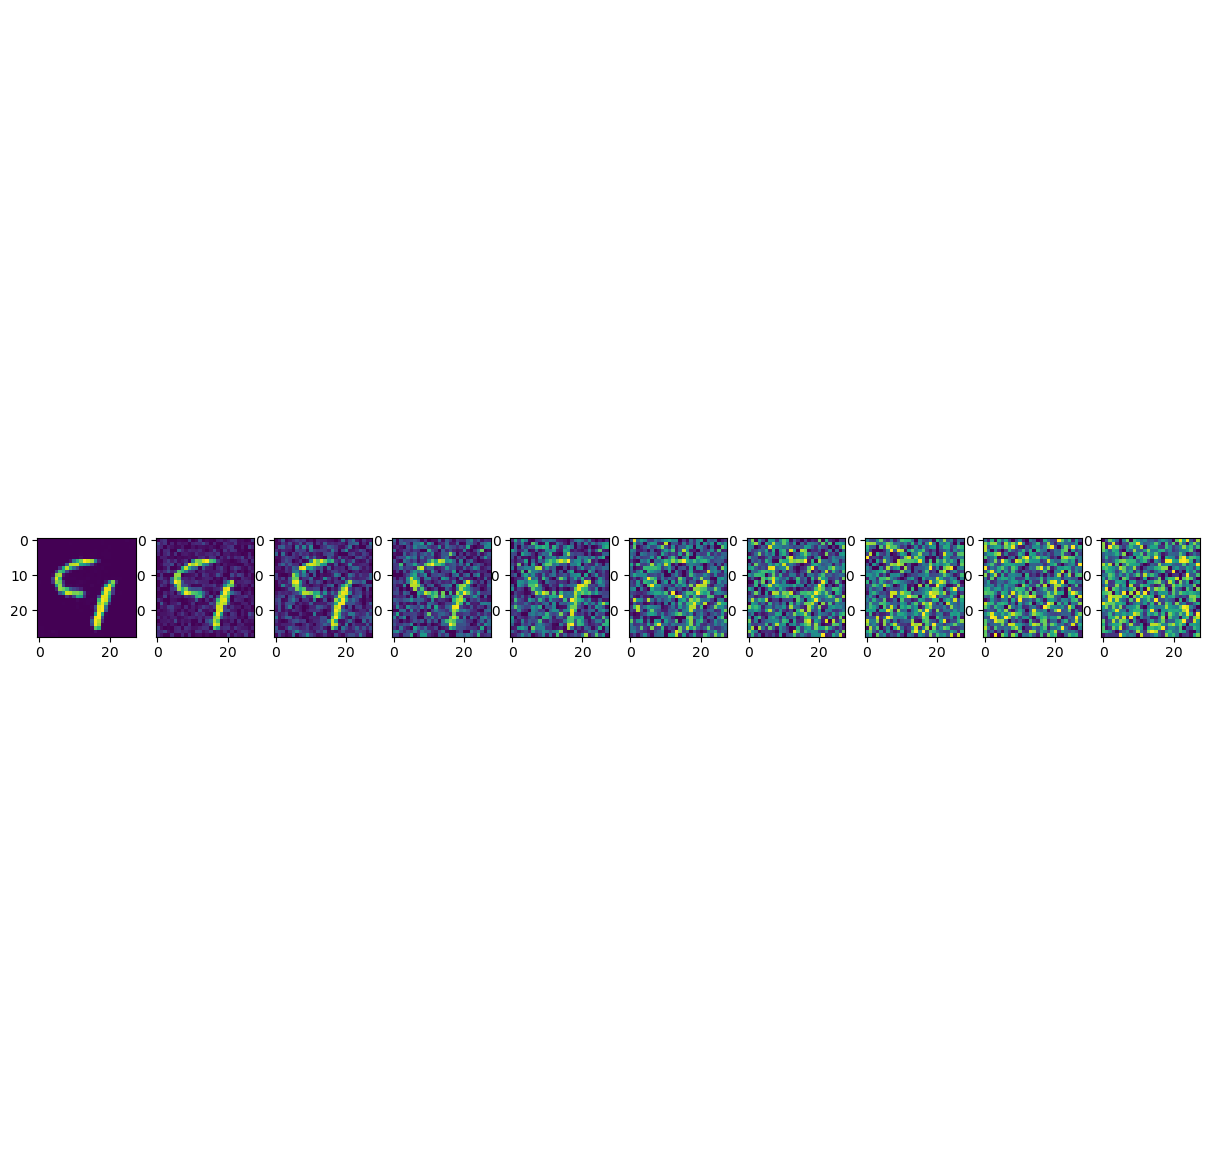

Epoch 25 | step 000 Loss: 0.07422518730163574 


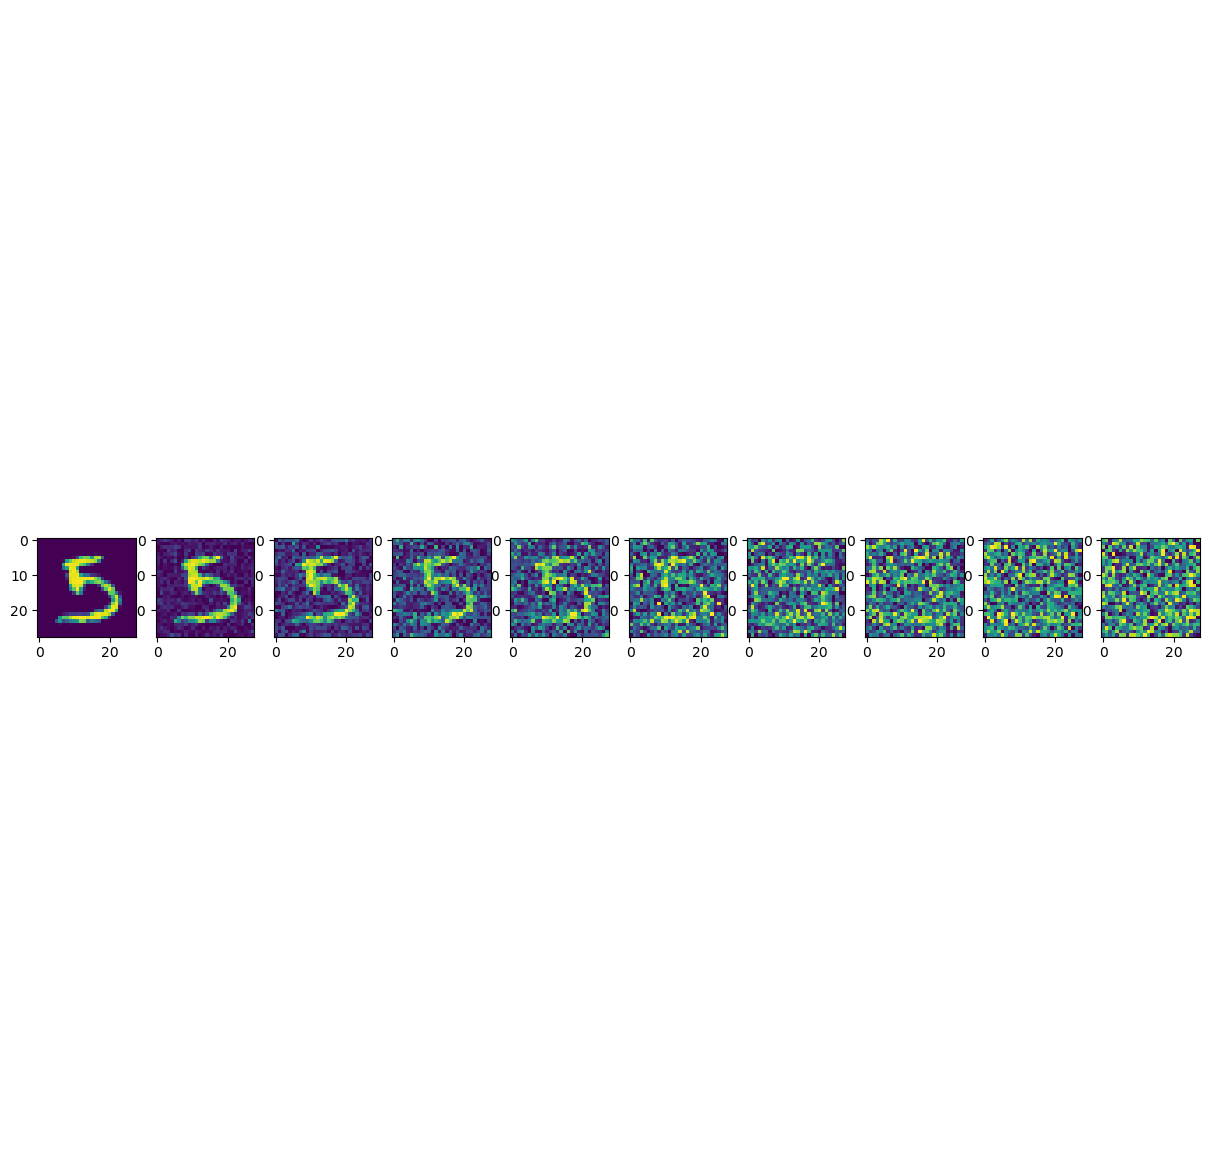

Epoch 30 | step 000 Loss: 0.07377829402685165 


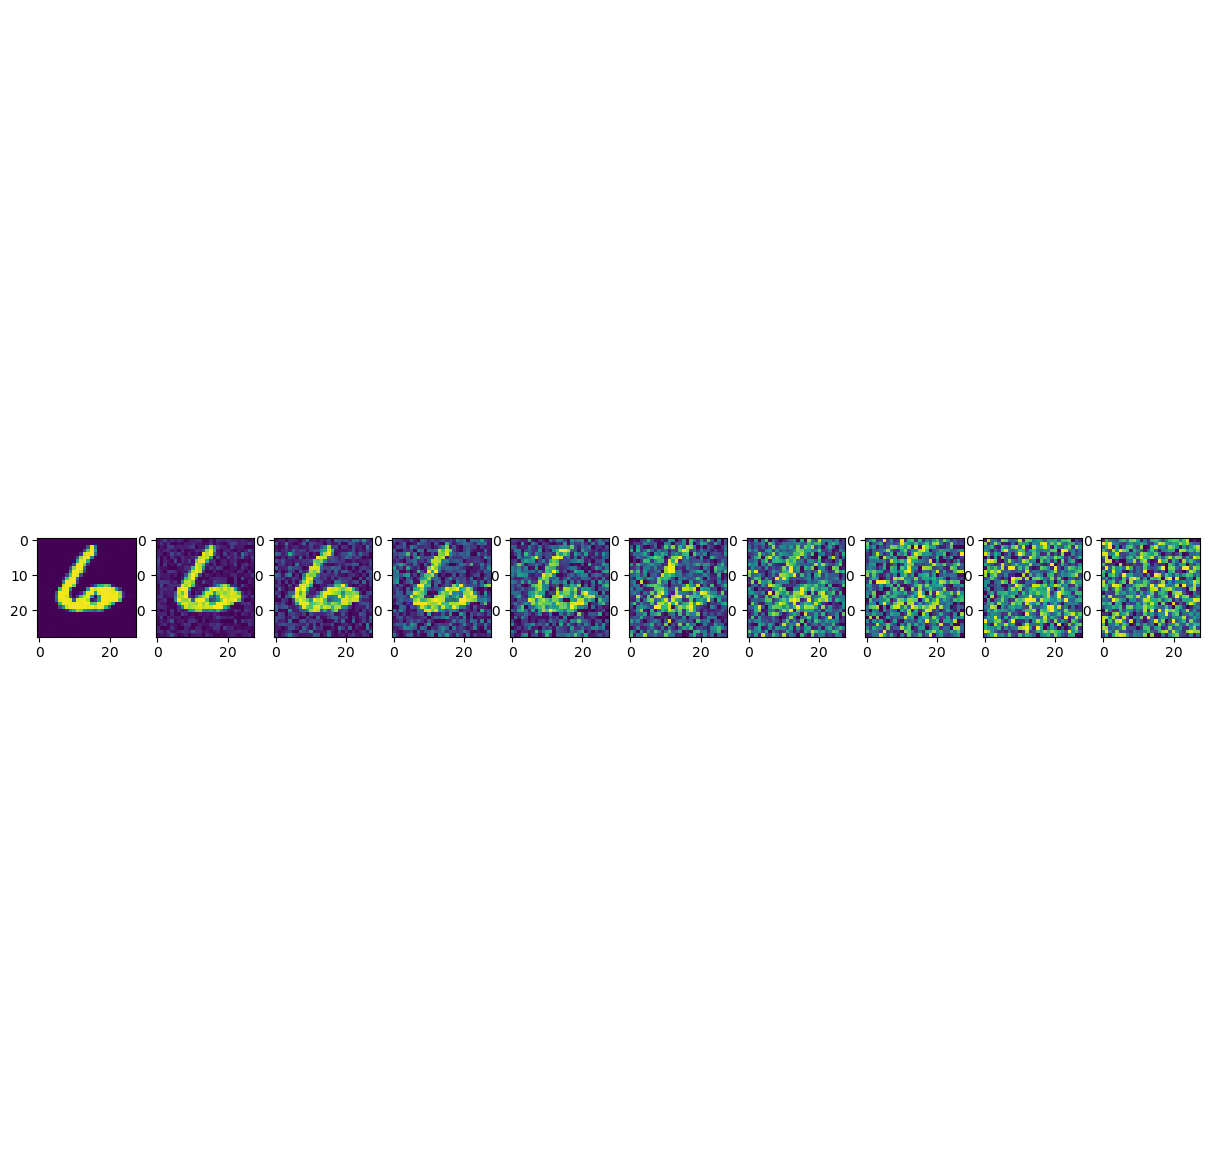

Epoch 35 | step 000 Loss: 0.07628866285085678 


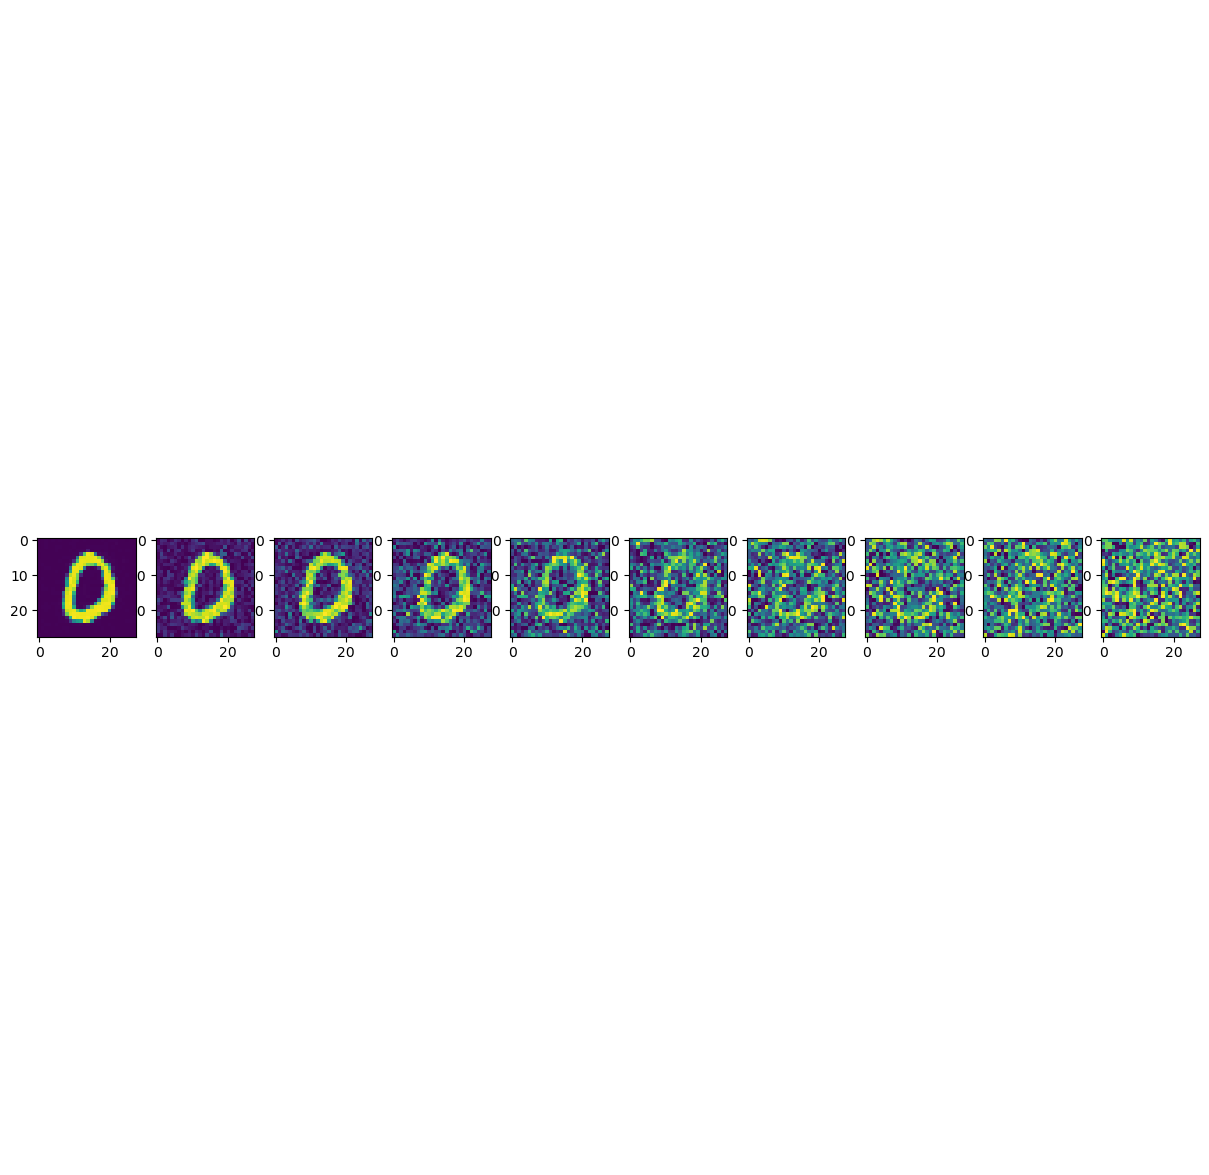

Epoch 40 | step 000 Loss: 0.07582461088895798 


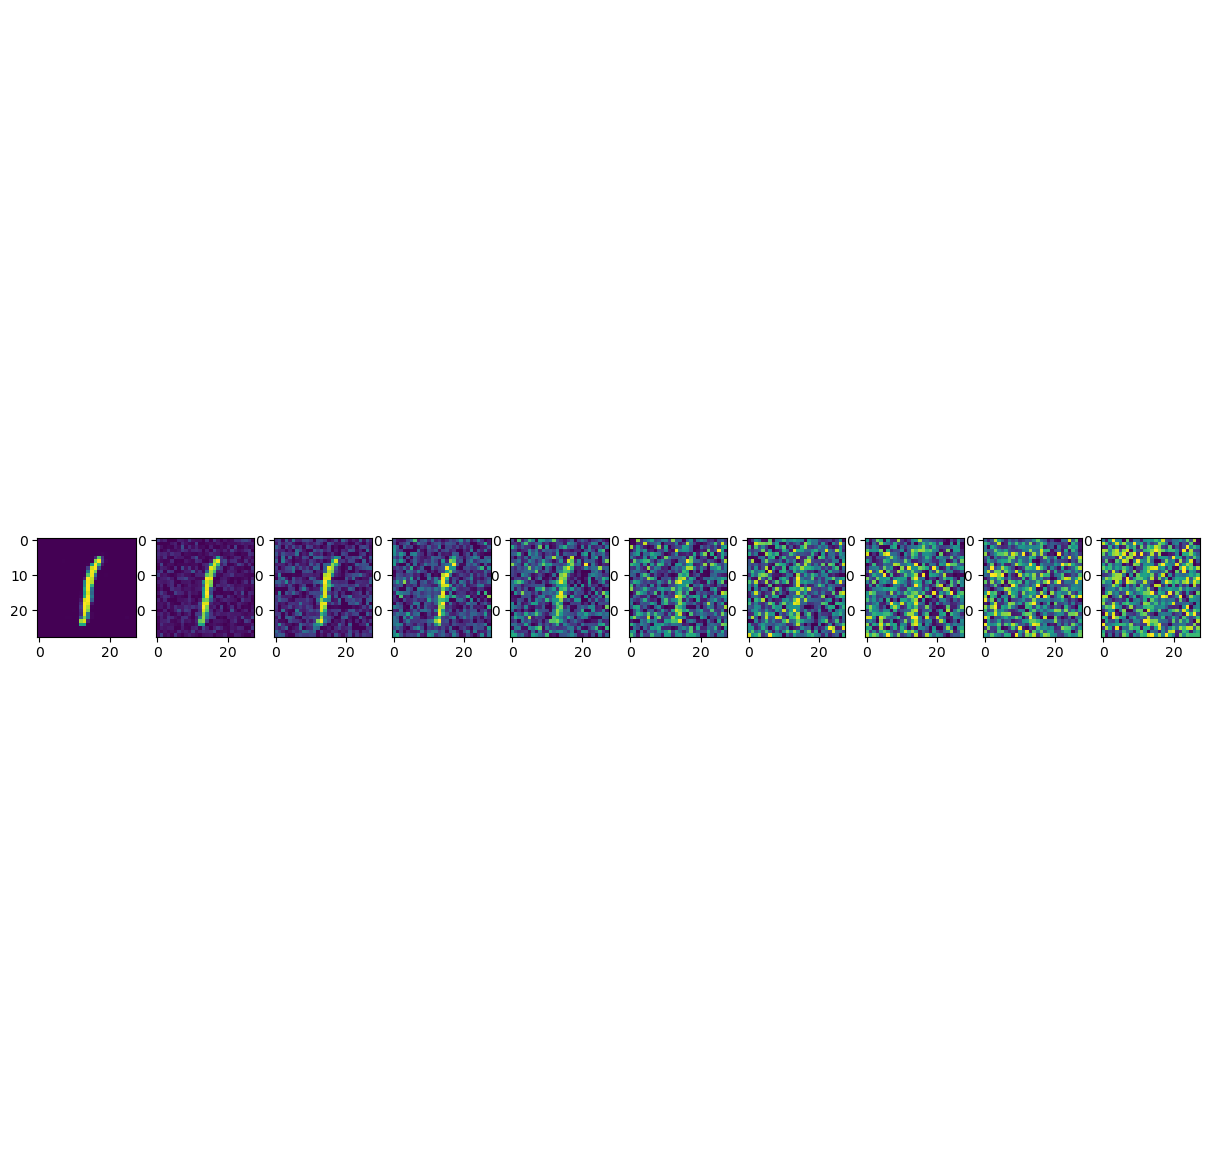

Epoch 45 | step 000 Loss: 0.07371959835290909 


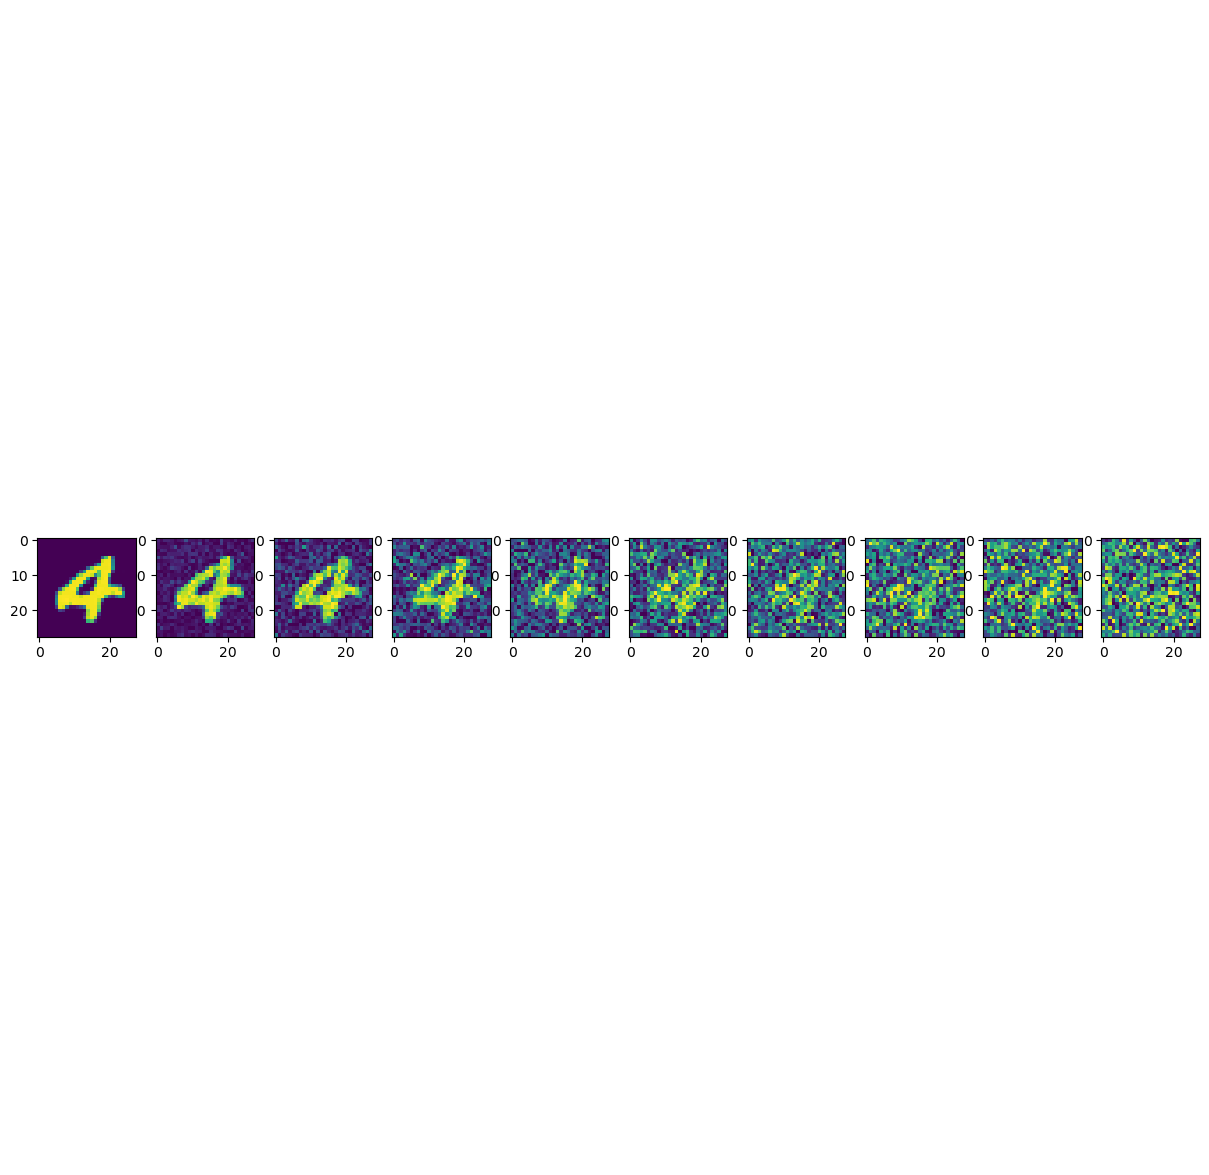

Epoch 50 | step 000 Loss: 0.07173968106508255 


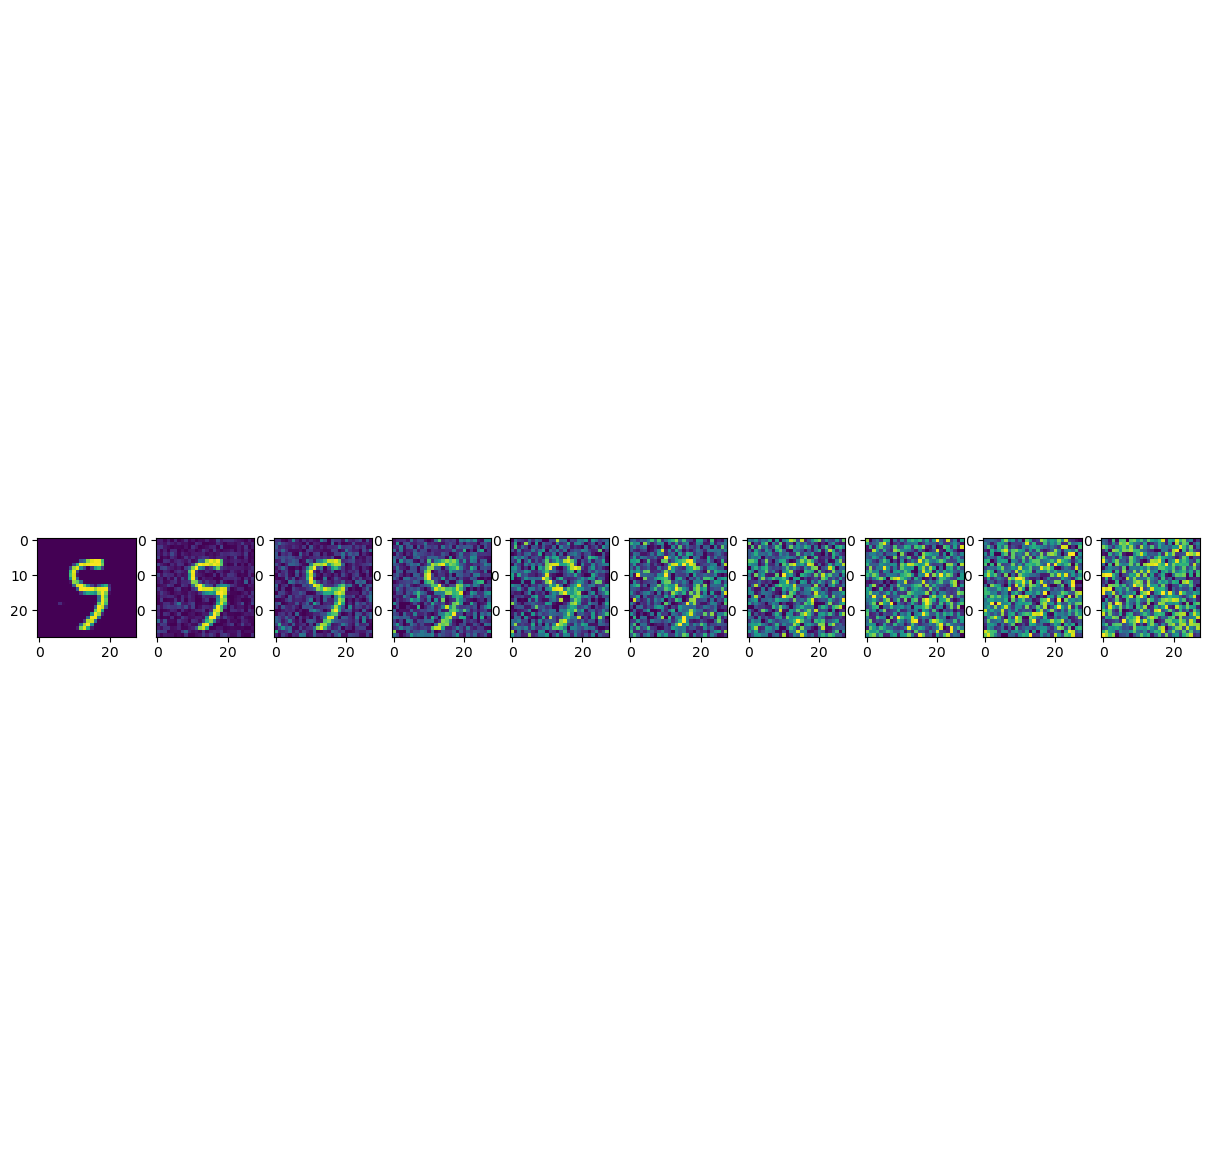

Epoch 55 | step 000 Loss: 0.07162269949913025 


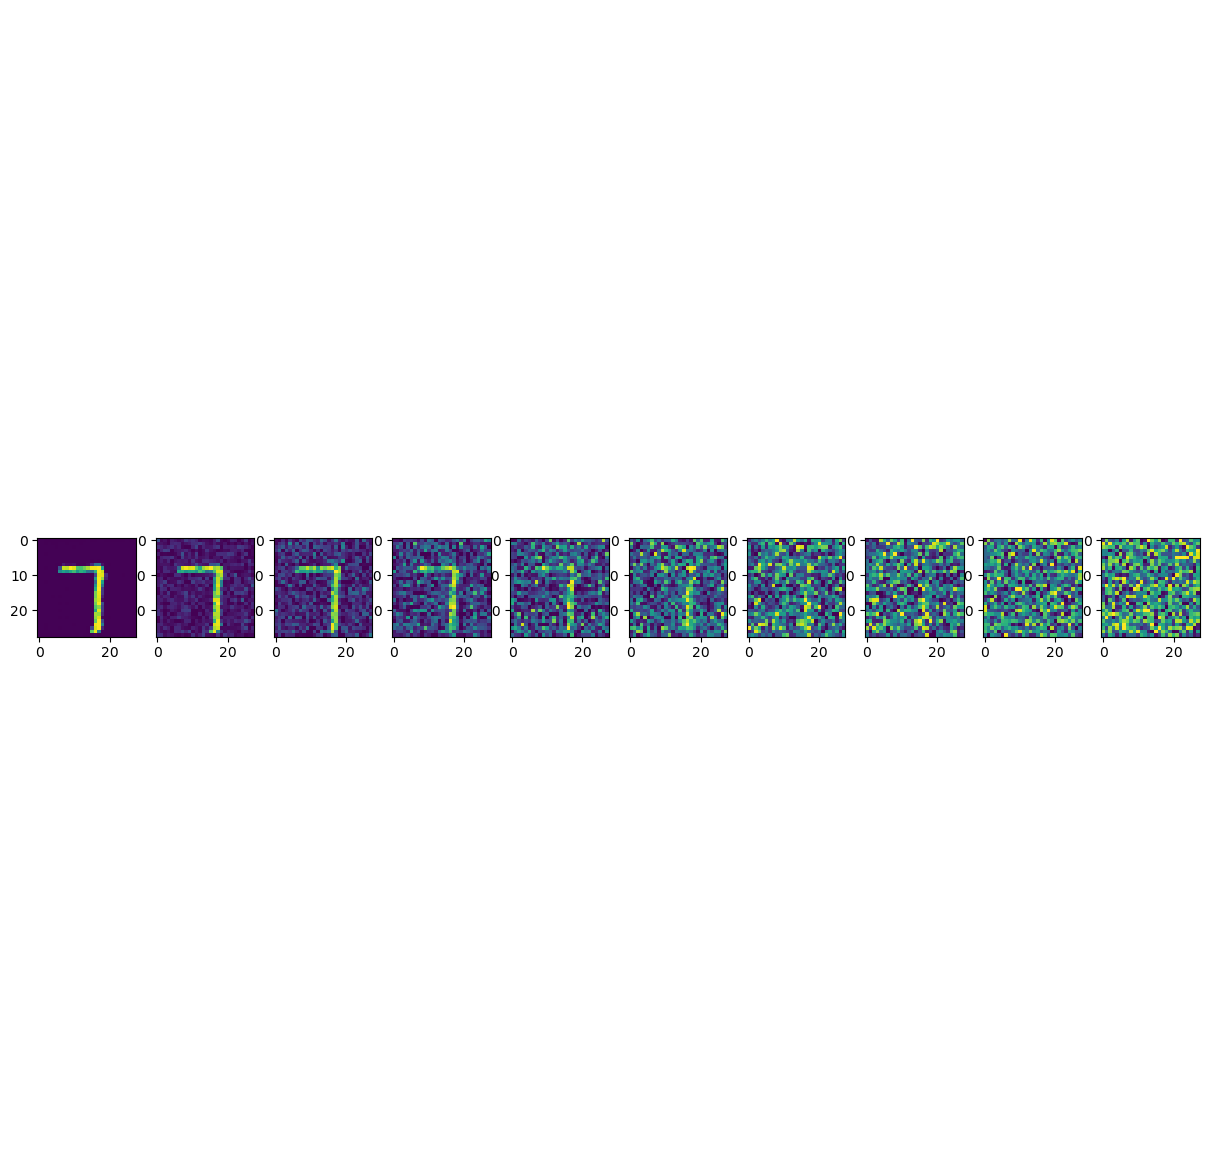

Epoch 60 | step 000 Loss: 0.06909354031085968 


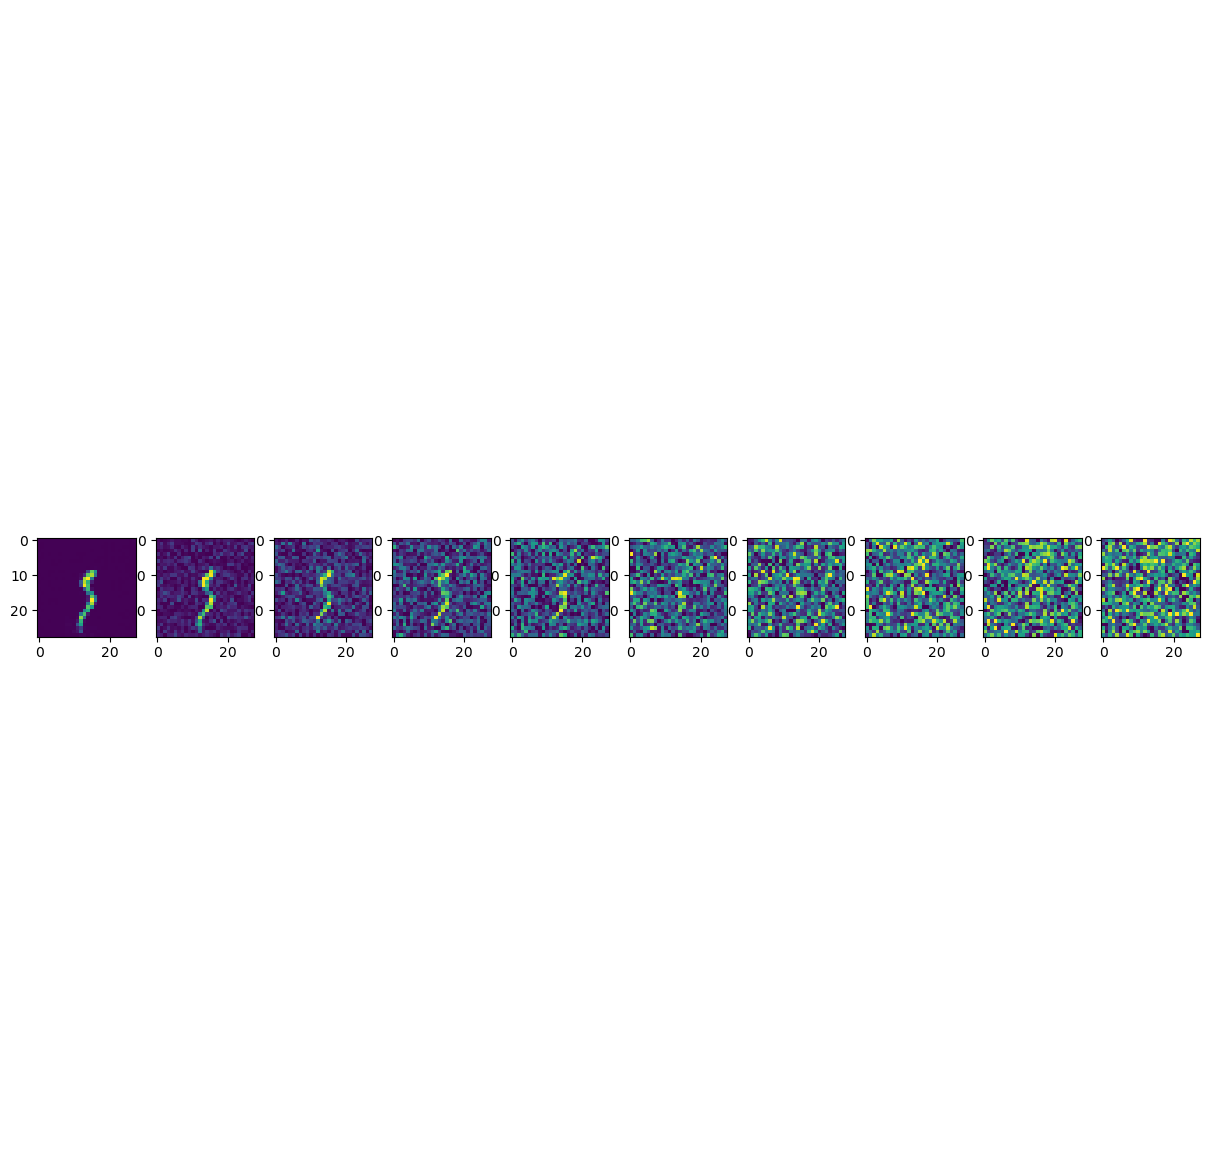

Epoch 65 | step 000 Loss: 0.07222043722867966 


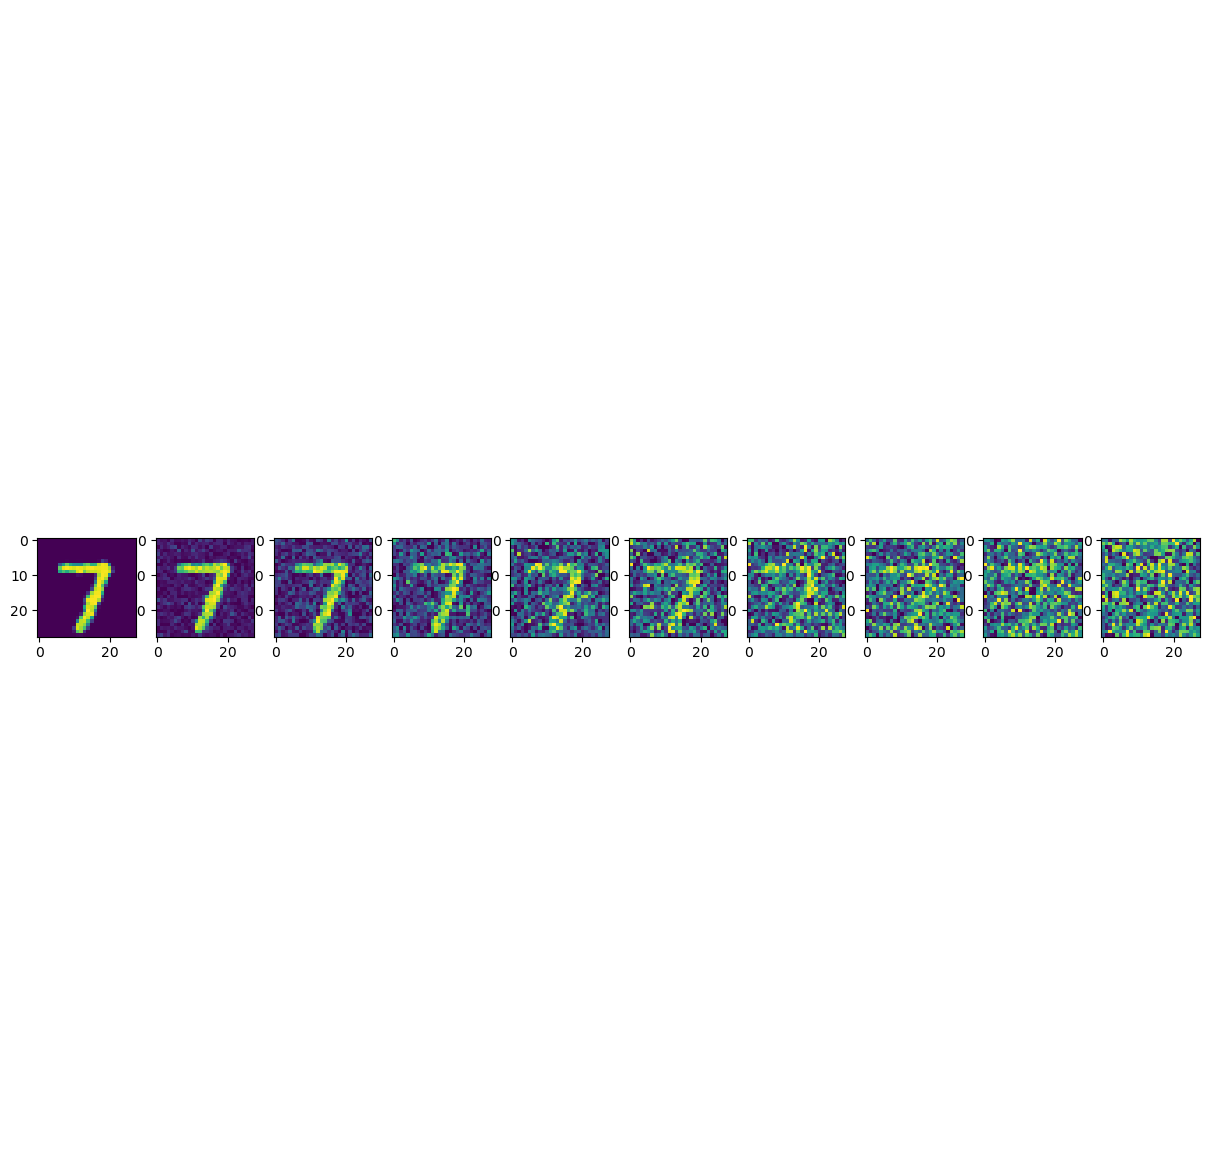

Epoch 70 | step 000 Loss: 0.07161390036344528 


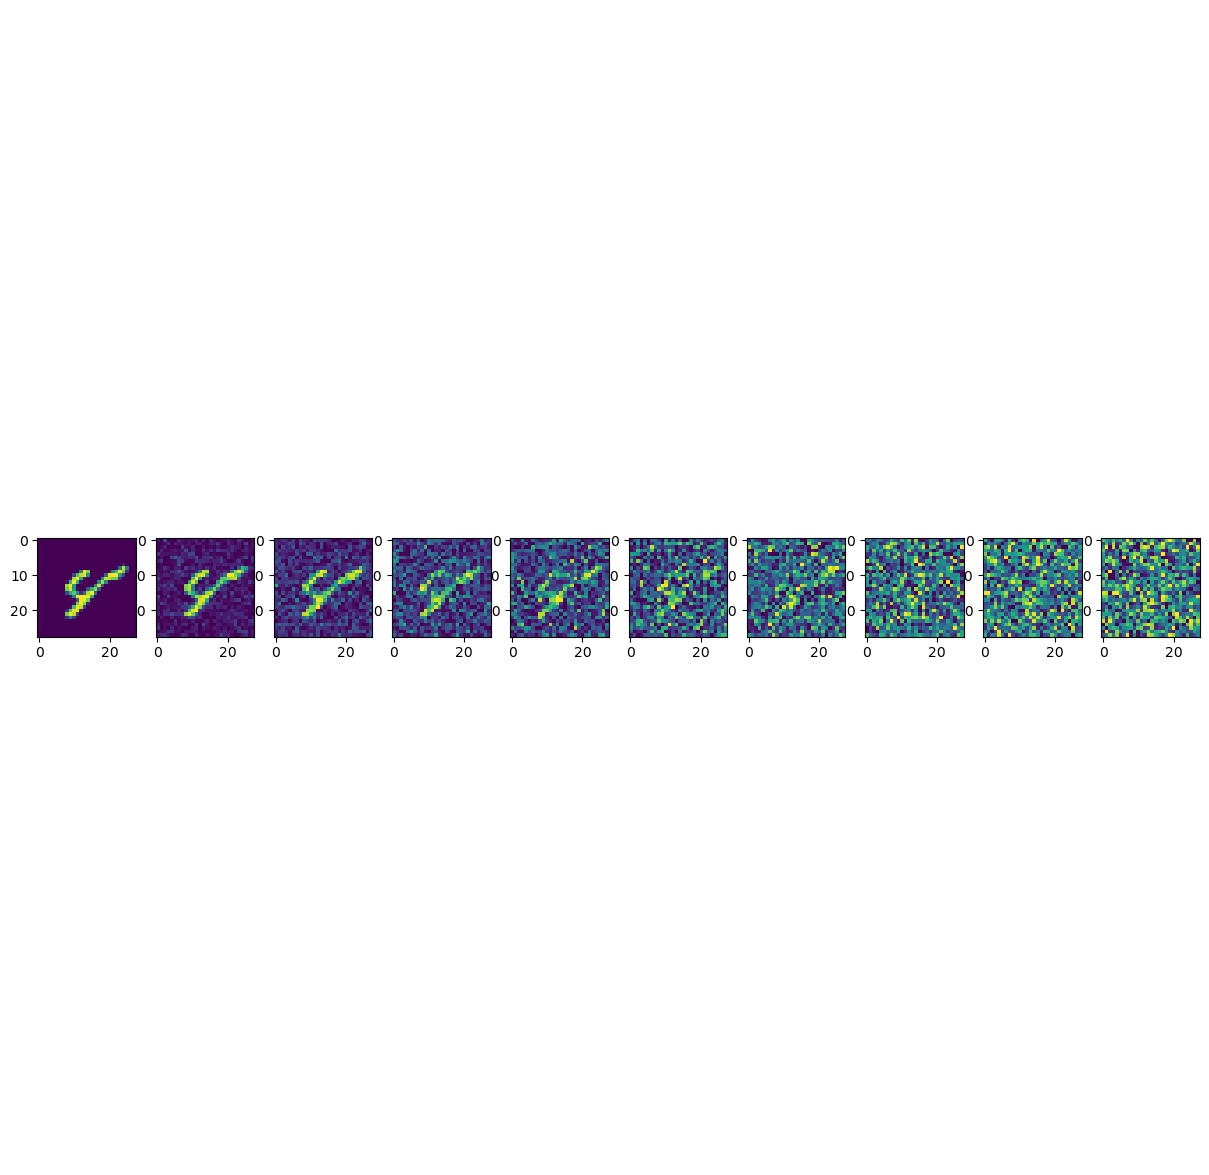

Epoch 75 | step 000 Loss: 0.06908553093671799 


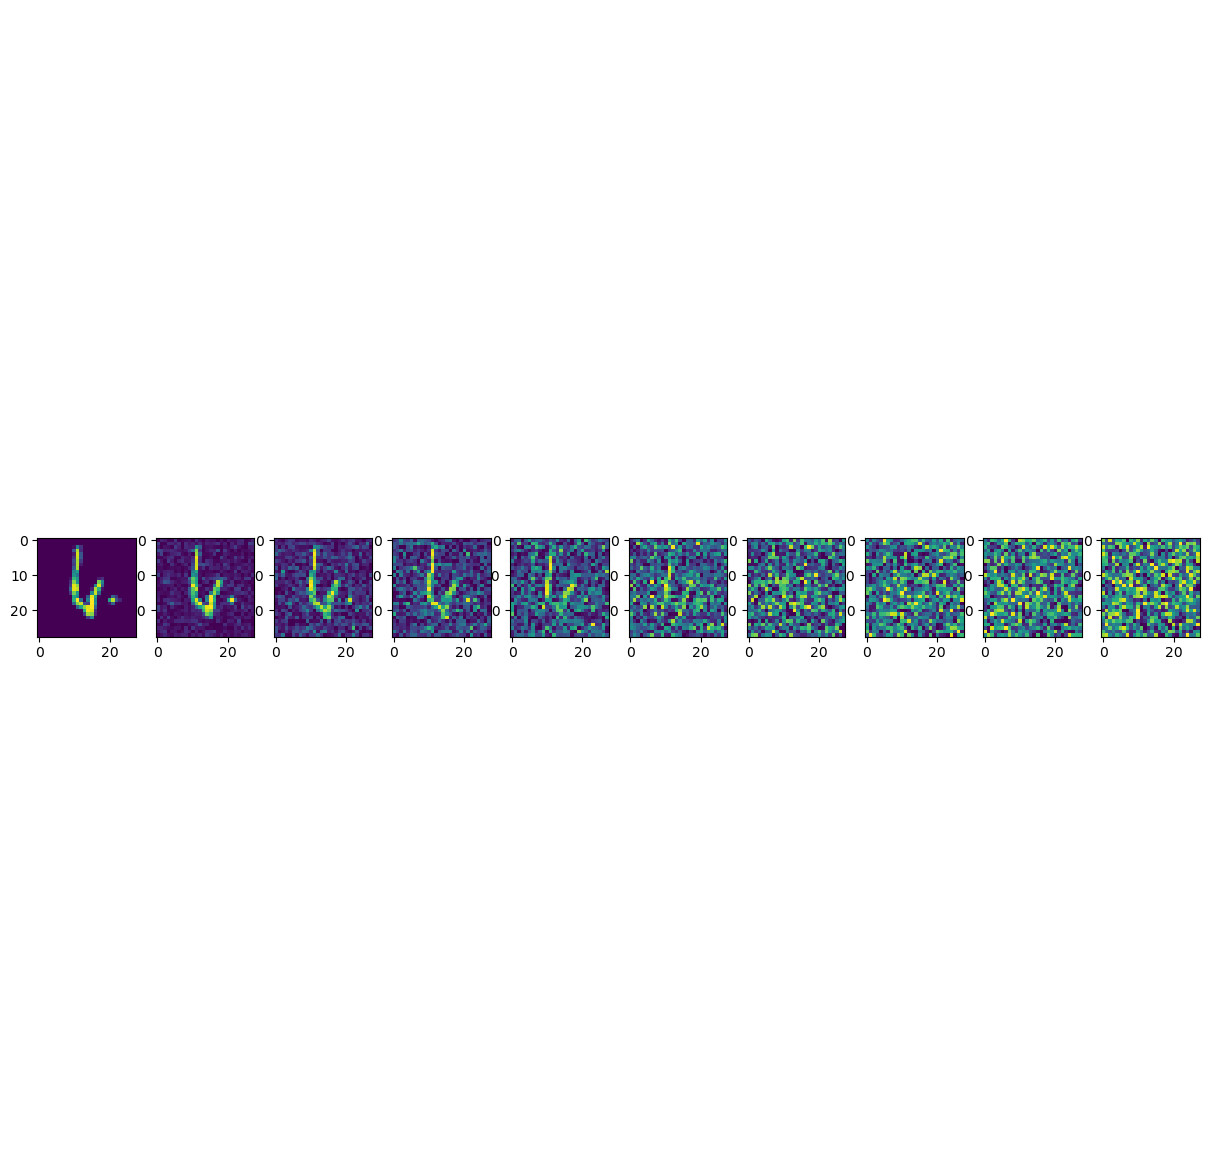

Epoch 80 | step 000 Loss: 0.06952033936977386 


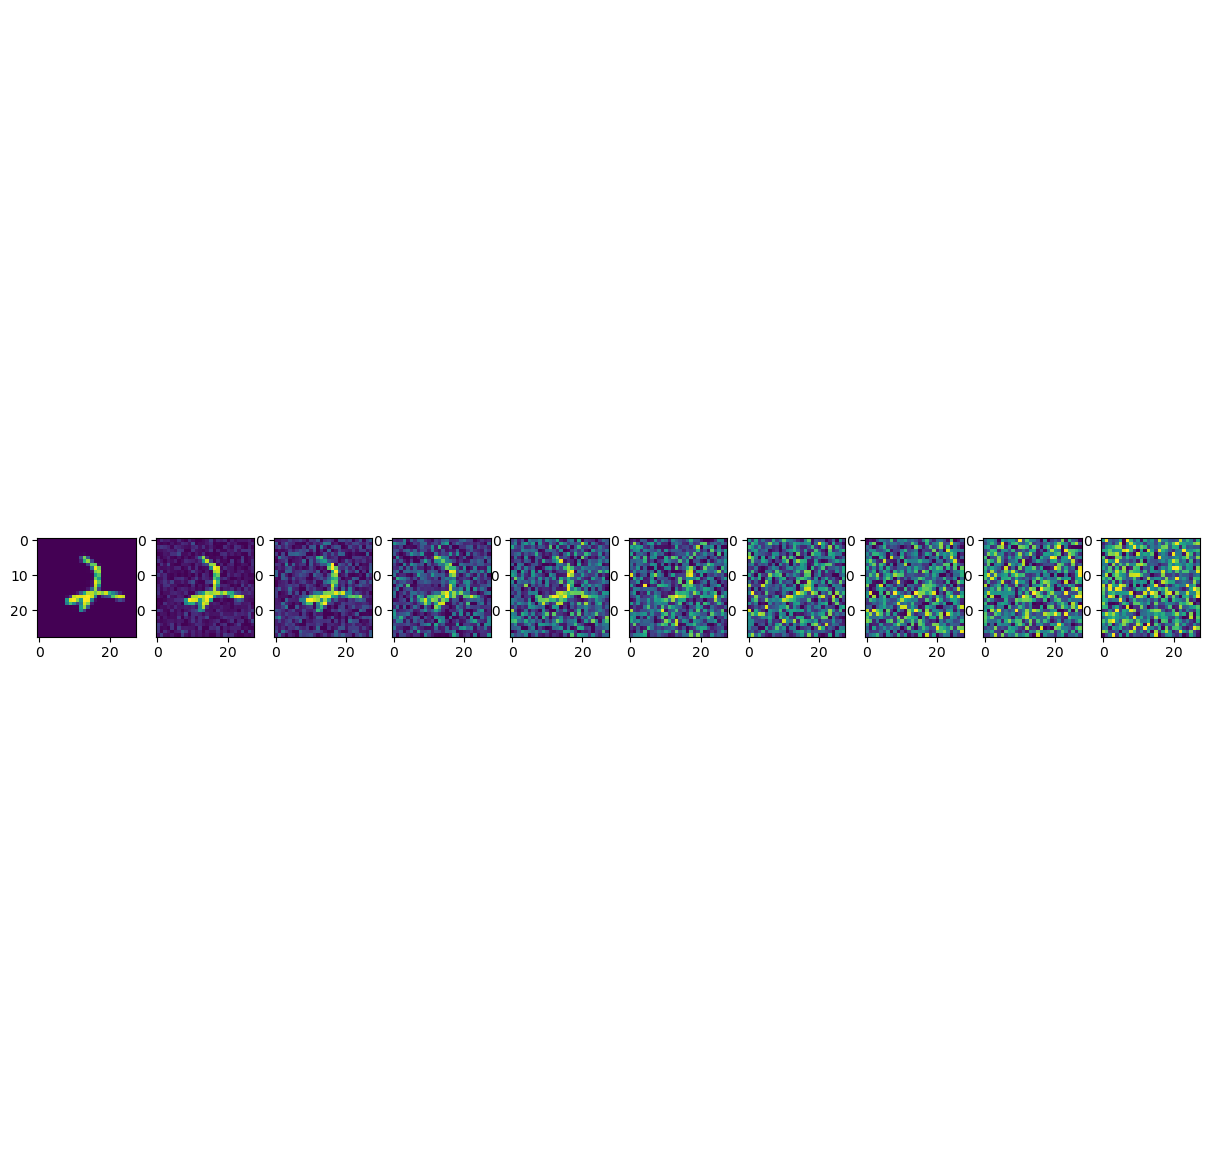

Epoch 85 | step 000 Loss: 0.07459571957588196 


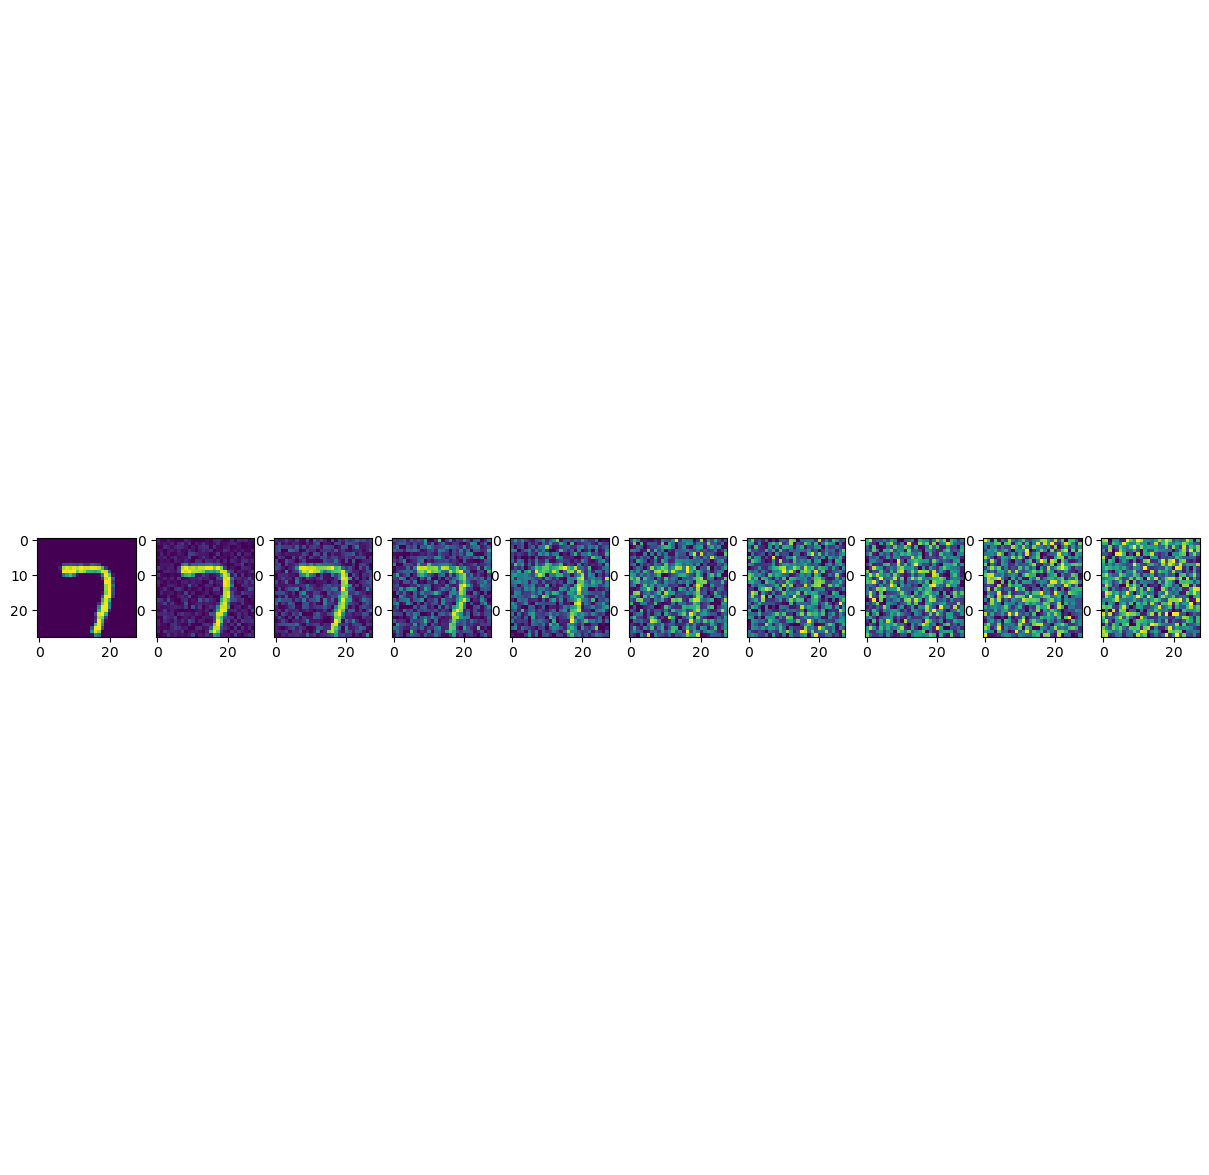

Epoch 90 | step 000 Loss: 0.06876557320356369 


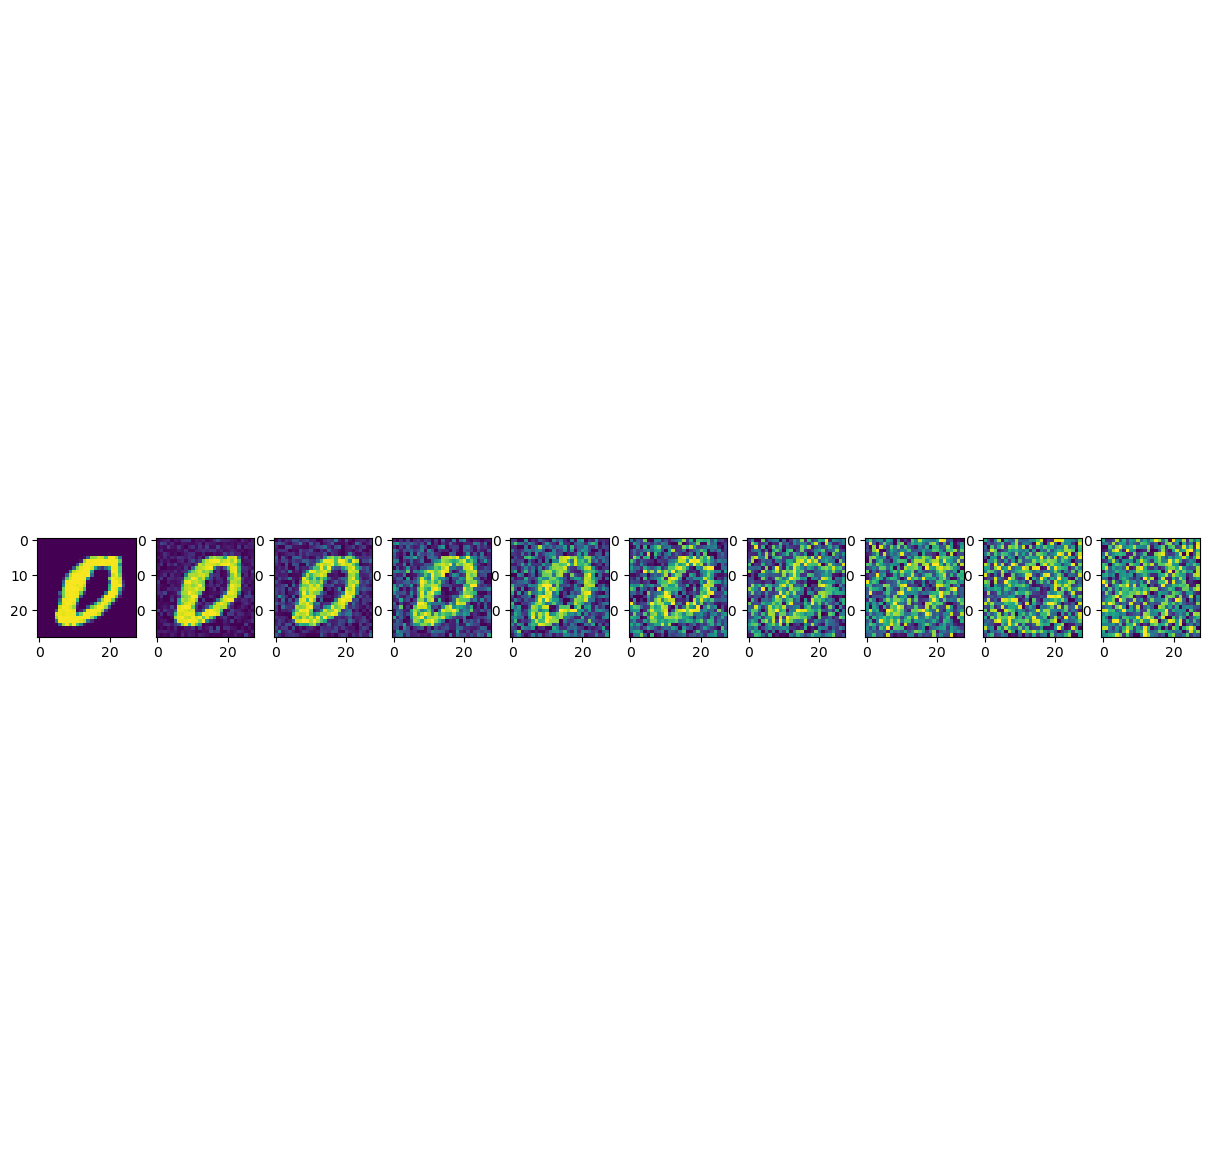

Epoch 95 | step 000 Loss: 0.0687299370765686 


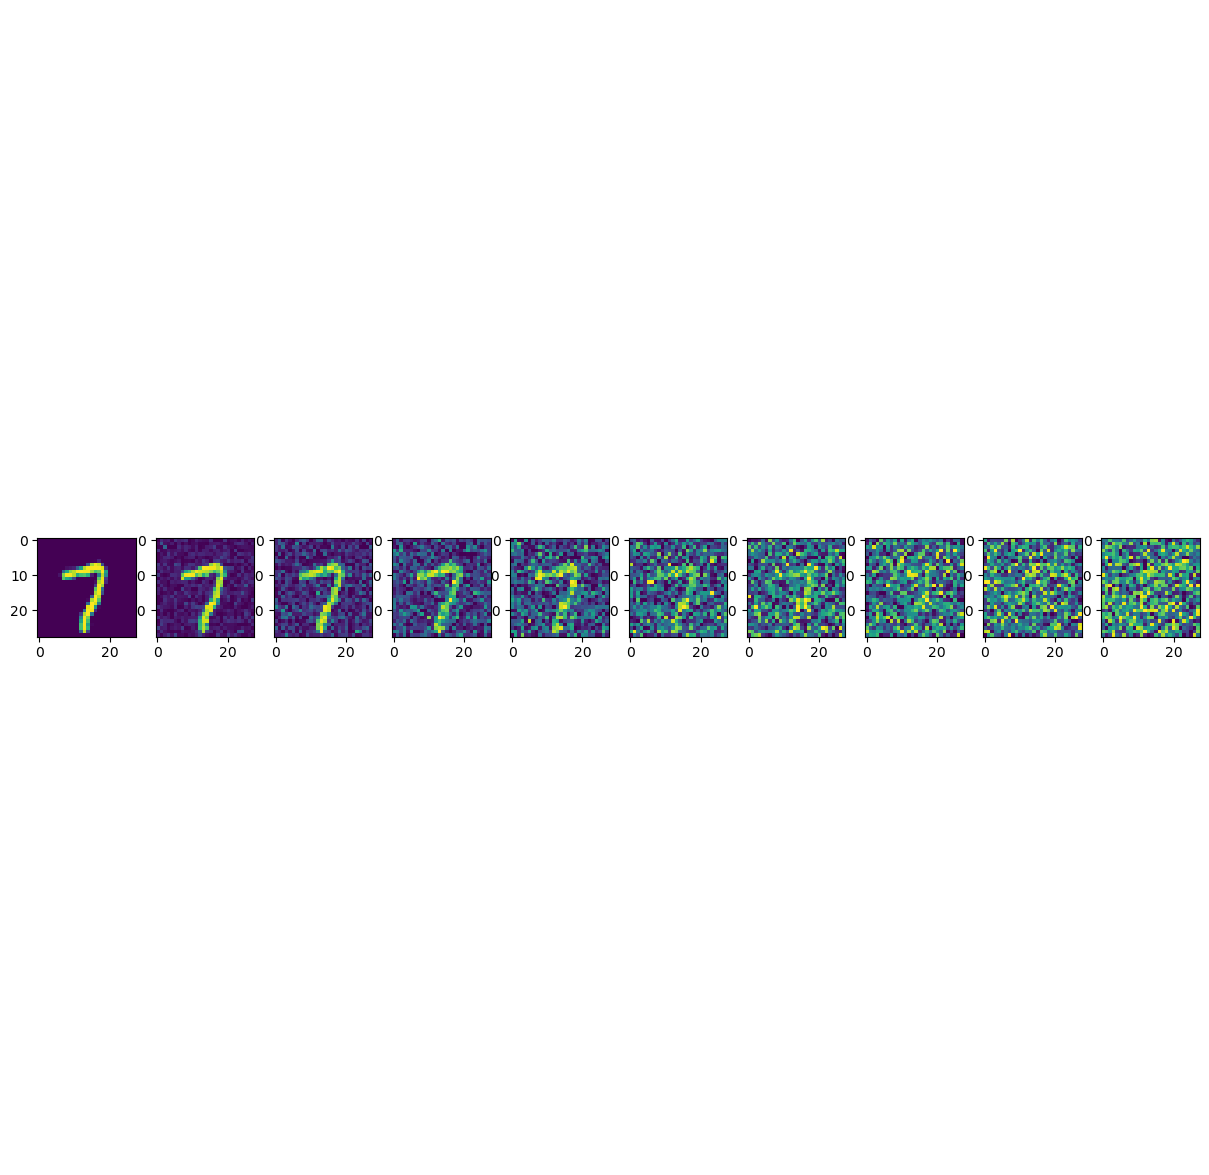

In [13]:
train_ddpm(model, train_dataloader, debug=True)

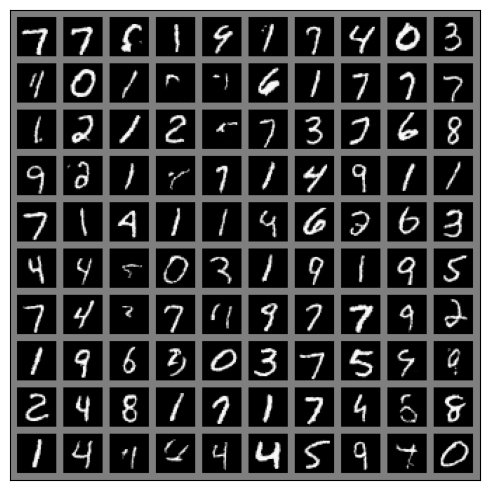

In [14]:
@torch.no_grad()
def sample(model, img):
    model.eval()
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        img = torch.clamp(img, -1.0, 1.0)
    return img

model.eval()
img = torch.randn(100, 1, 28, 28).to(device)
img = sample(model, img)
fig, ax = plt.subplots(figsize=(5, 5))
show_tensor_image(make_grid(img.detach().cpu(),10,5))
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [15]:
collapse_size = 2560

def collapse_ddpm(ddpm_init, ddpm_start, generations=20, debug=False):
    samples = []
    loss = []
    ddpm = copy.deepcopy(ddpm_start).to(device)

    for i in range(generations):
        if debug:
            print(f"Generation {i}")
        img = torch.randn(collapse_size, 1, 28, 28).to(device)
        img = sample(ddpm, img).detach()
        samples.append(img)
        sample_loss = get_loss(ddpm_init, img, torch.zeros(collapse_size).long().to(device)).detach()
        loss.append(sample_loss)

        dataset = TensorDataset(img, torch.zeros(img.shape[0]).to(device))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        train_ddpm(ddpm, dataloader)

    return samples, loss

In [16]:
samples, loss = collapse_ddpm(model, model, debug=True)

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Generation 10
Generation 11
Generation 12
Generation 13
Generation 14
Generation 15
Generation 16
Generation 17
Generation 18
Generation 19


In [17]:
torch.save(samples, "../outputs/tensors/samples_ddpm.pt")
torch.save(loss, "../outputs/tensors/loss_ddpm.pt")

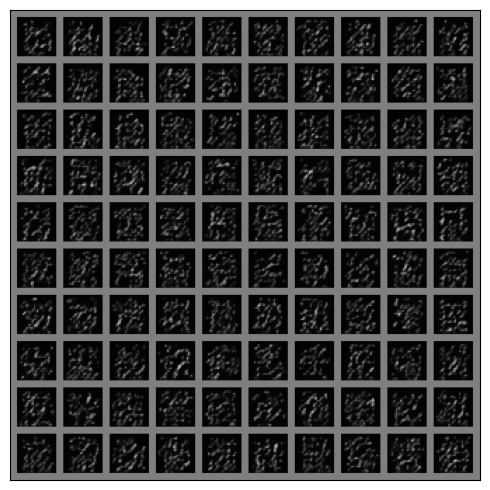

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
show_tensor_image(make_grid(samples[8][:100].detach().cpu(),10,5))
plt.xticks([])
plt.yticks([])

plt.tight_layout()

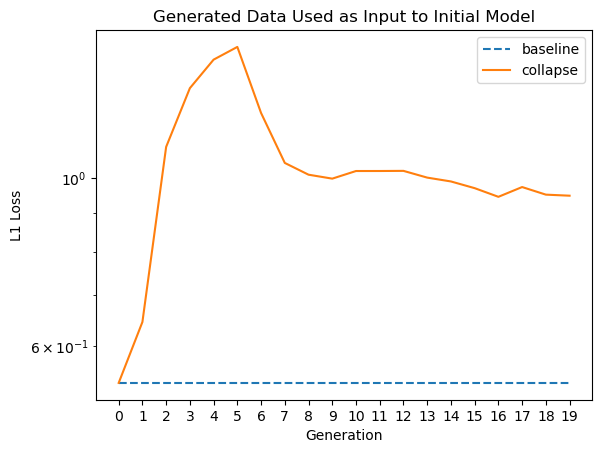

In [31]:
plt.plot([loss[0].item() for i in range(20)], label="baseline", linestyle='dashed')
plt.plot([l.item() for l in loss], label="collapse")
plt.legend()
plt.ylabel("L1 Loss")
plt.xlabel("Generation")
plt.title("Generated Data Used as Input to Initial Model")
plt.xticks(range(0, 20))
plt.yscale("log")

plt.savefig("../images/ddpm_quantified.png")
plt.show()

# Custom Implementation

In [33]:
def extend_tensor(tensor):
    return tensor.view(tensor.shape[0], 1, 1, 1)

def forward_process_iter(x_0):
    x_tn1 = x_0
    for t in range(T):
        x_t = torch.normal(torch.sqrt(1 - beta[t]) * x_tn1, beta[t])
        x_tn1 = x_t
    return x_t

def forward_process(x_0, t):
    epsilon = torch.randn(x_0.shape).to(device)
    x_t = torch.sqrt(extend_tensor(alpha_bar[t])) * x_0 + torch.sqrt(1 - extend_tensor(alpha_bar[t])) * epsilon
    return x_t, epsilon

In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [28]:
@torch.no_grad()
def sample(model, x_shape):
    x_t = torch.randn(x_shape).to(device)
    for t in reversed(range(T)):
        z = torch.randn(x_shape).to(device) if t > 1 else 0
        t_vec = t * torch.ones(x_shape[0]).to(device)
        rho_t = torch.sqrt((1-alpha_bar[t-1]) / (1 - alpha_bar[t]) * beta[t])
        x_t = 1 / torch.sqrt(alpha[t]) * (x_t - (1 - alpha[t]/torch.sqrt(1-alpha[t])) * model(x_t, t_vec)) + torch.sqrt(rho_t) * z
    return x_t

def get_loss(model, x_0, t):
    x_t, epsilon = forward_process(x_0, t)
    epsilon_pred = model(x_t, t)
    return F.mse_loss(epsilon, epsilon_pred)

In [34]:
unet = UNET()
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate)
unet.train()
for epoch in range(num_epochs):
    for image_batch, _ in train_dataloader:
        optimizer.zero_grad()
        image_batch = image_batch.to(device)
        b_size = image_batch.shape[0]
        t = torch.randint(0, T, (b_size,)).to(device)
        loss = get_loss(unet, image_batch, t)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} | Loss: {loss.item()}")

TypeError: UNET.forward() takes 2 positional arguments but 3 were given

In [7]:
for image_batch, _ in train_dataloader:
    image_batch = image_batch.to(device)
    x_T, _ = forward_process(image_batch, 100)
    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(make_grid(x_T.cpu().data[:100],10,5))
    # plt.show()
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    break

NameError: name 'forward_process' is not defined

In [ ]:
x = sample(unet, (100, 1, 28, 28))
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(x.cpu().data,10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()